# Grover's algorithm

Estimated QPU usage: 4 seconds (tested on IBM Nairobi)

## Background
Amplitude amplification is a general purpose quantum algorithm, or subroutine, that can be used to obtain a quadratic speedup over a handful of classical algorithms. Grover’s algorithm was the first to demonstrate this speedup on unstructured search problems. Formulating a Grover's search problem requires an oracle function that marks one or more computational basis states as the states we are interested in finding, and an amplification circuit that increases the amplitude of marked states, consequently suppressing the remaining states.

Here, we demonstrate how to construct Grover oracles and use the GroverOperator from the Qiskit circuit library to easily set up a Grover's search instance. The runtime Sampler primitive allows seamless execution of Grover circuits.

### Requirements
Before starting this tutorial, ensure that you have the following installed:  
Qiskit SDK 1.0 or later, with visualization support ( pip install 'qiskit[visualization]' )  
Qiskit Runtime ( pip install qiskit-ibm-runtime ) 0.22 or later  

## Step 1. Map classical inputs to a quantum problem


Grover's algorithm requires an oracle that specifies one or more marked computational basis states, where "marked" means a state with a phase of -1. A controlled-Z gate, or its multi-controlled generalization over 
N
N qubits, marks the 
2
N
−
1
2 
N
 −1 state ( '1' *
N
N bit-string). Marking basis states with one or more '0' in the binary representation requires applying X-gates on the corresponding qubits before and after the controlled-Z gate; equivalent to having an open-control on that qubit. In the following code, we define an oracle that does just that, marking one or more input basis states defined through their bit-string representation. The MCMT gate is used to implement the multi-controlled Z-gate.

In [1]:
# Built-in modules
import math

# Imports from Qiskit
from qiskit import QuantumCircuit
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution

# Imports from Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [2]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_kyiv'

In [3]:
def grover_oracle(marked_states):
    """Build a Grover oracle for multiple marked states

    Here we assume all input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    # Mark each target state in the input list
    for target in marked_states:
        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    return qc

Specific Grover's instance  
Now that we have the oracle function, we can define a specific instance of Grover search. In this example we will mark two computational states out of the eight available in a three-qubit computational space:

C:\Users\Admin\AppData\Local\Temp\ipykernel_12368\2149212773.py:27: DeprecationWarning: The class ``qiskit.circuit.library.generalized_gates.mcmt.MCMT`` is deprecated as of Qiskit 1.4. It will be removed no earlier than 3 months after the release date. Use MCMTGate instead.
  qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)


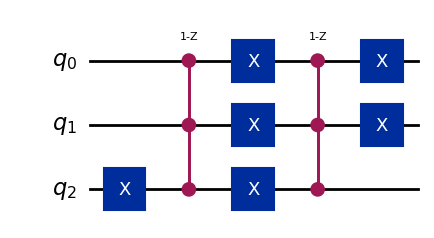

In [4]:
marked_states = ["011", "100"]

oracle = grover_oracle(marked_states)
oracle.draw(output="mpl", style="iqp")